In [1]:
import tensorflow as tf; print(tf.__version__)

2.0.0


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

#### GPU Hickups

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# physical_devices = tf.config.experimental.list_physical_device  

tf.config.experimental.set_memory_growth(physical_devices[0], True) 
assert tf.config.experimental.get_memory_growth(physical_devices[0]) 


In [4]:
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

True

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4990058431620739436
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18194707926925404674
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2329343209782439116
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22748702311
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 12283561690562766932
physical_device_desc: "device: 0, name: Tesla M40 24GB, pci bus id: 0000:8a:00.0, compute capability: 5.2"
]


In [7]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

### Detection CNN

In [7]:
class FireDetectionNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        model.add(SeparableConv2D(16, (7, 7), padding="same",
                                  input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(SeparableConv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(SeparableConv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # second set of FC => RELU layers
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [18]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile

In [19]:
class LearningRateFinder:
    def __init__(self, model, stopFactor=4, beta=0.98):
        # store the model, stop factor, and beta value (for computing
        # a smoothed, average loss)
        self.model = model
        self.stopFactor = stopFactor
        self.beta = beta

        # initialize our list of learning rates and losses,
        # respectively
        self.lrs = []
        self.losses = []

        # initialize our learning rate multiplier, average loss, best
        # loss found thus far, current batch number, and weights file
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None

    def reset(self):
        # re-initialize all variables from our constructor
        self.lrs = []
        self.losses = []
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None

    def is_data_iter(self, data):
        # define the set of class types we will check for
        iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
             "DataFrameIterator", "Iterator", "Sequence"]

        # return whether our data is an iterator
        return data.__class__.__name__ in iterClasses

    def on_batch_end(self, batch, logs):
        # grab the current learning rate and add log it to the list of
        # learning rates that we've tried
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # grab the loss at the end of this batch, increment the total
        # number of batches processed, compute the average average
        # loss, smooth it, and update the losses list with the
        # smoothed value
        l = logs["loss"]
        self.batchNum += 1
        self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
        smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
        self.losses.append(smooth)

        # compute the maximum loss stopping factor value
        stopLoss = self.stopFactor * self.bestLoss

        # check to see whether the loss has grown too large
        if self.batchNum > 1 and smooth > stopLoss:
            # stop returning and return from the method
            self.model.stop_training = True
            return

        # check to see if the best loss should be updated
        if self.batchNum == 1 or smooth < self.bestLoss:
            self.bestLoss = smooth

        # increase the learning rate
        lr *= self.lrMult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, trainData, startLR, endLR, epochs=None,
        stepsPerEpoch=None, batchSize=32, sampleSize=2048,
        classWeight=None, verbose=1):
        # reset our class-specific variables
        self.reset()

        # determine if we are using a data generator or not
        useGen = self.is_data_iter(trainData)

        # if we're using a generator and the steps per epoch is not
        # supplied, raise an error
        if useGen and stepsPerEpoch is None:
            msg = "Using generator without supplying stepsPerEpoch"
            raise Exception(msg)

        # if we're not using a generator then our entire dataset must
        # already be in memory
        elif not useGen:
            # grab the number of samples in the training data and
            # then derive the number of steps per epoch
            numSamples = len(trainData[0])
            stepsPerEpoch = np.ceil(numSamples / float(batchSize))

        # if no number of training epochs are supplied, compute the
        # training epochs based on a default sample size
        if epochs is None:
            epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))

        # compute the total number of batch updates that will take
        # place while we are attempting to find a good starting
        # learning rate
        numBatchUpdates = epochs * stepsPerEpoch

        # derive the learning rate multiplier based on the ending
        # learning rate, starting learning rate, and total number of
        # batch updates
        self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)

        # create a temporary file path for the model weights and
        # then save the weights (so we can reset the weights when we
        # are done)
        self.weightsFile = tempfile.mkstemp()[1]
        self.model.save_weights(self.weightsFile)

        # grab the *original* learning rate (so we can reset it
        # later), and then set the *starting* learning rate
        origLR = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, startLR)

        # construct a callback that will be called at the end of each
        # batch, enabling us to increase our learning rate as training
        # progresses
        callback = LambdaCallback(on_batch_end=lambda batch, logs:
            self.on_batch_end(batch, logs))

        # check to see if we are using a data iterator
        if useGen:
            self.model.fit_generator(
                trainData,
                steps_per_epoch=stepsPerEpoch,
                epochs=epochs,
                class_weight=classWeight,
                verbose=verbose,
                callbacks=[callback])

        # otherwise, our entire training data is already in memory
        else:
            # train our model using Keras' fit method
            self.model.fit(
                trainData[0], trainData[1],
                batch_size=batchSize,
                epochs=epochs,
                class_weight=classWeight,
                callbacks=[callback],
                verbose=verbose)

        # restore the original model weights and learning rate
        self.model.load_weights(self.weightsFile)
        K.set_value(self.model.optimizer.lr, origLR)

    def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
        # grab the learning rate and losses values to plot
        lrs = self.lrs[skipBegin:-skipEnd]
        losses = self.losses[skipBegin:-skipEnd]

        # plot the learning rate vs. loss
        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")
        
        # if the title is not empty, add it to the plot
        if title != "":
            plt.title(title)

In [12]:
# import the necessary packages
import os

# initialize the path to the fire and non-fire dataset directories
FIRE_PATH = "/userdata/kerasData/HPWREN-data/AFTER/images"
NON_FIRE_PATH = "/userdata/kerasData/HPWREN-data/BEFORE/images"

# initialize the class labels in the dataset
CLASSES = ["Non-Fire", "Fire"]

# define the size of the training and testing split
TRAIN_SPLIT = 0.75
TEST_SPLIT = 0.25

In [13]:
# define the initial learning rate, batch size, and number of epochs
INIT_LR = 1e-3
BATCH_SIZE = 64
NUM_EPOCHS = 50

In [14]:

# set the path to the serialized model after training
MODEL_PATH = os.path.sep.join(["output", "fire_detection.model"])

# define the path to the output learning rate finder plot and
# training history plot
LRFIND_PLOT_PATH = os.path.sep.join(["/userdata/kerasData", "output", "lrfindd_plot.png"])
TRAINING_PLOT_PATH = os.path.sep.join(["/userdata/kerasData", "output", "training_plot.png"])

# define the path to the output directory that will store our final
# output with labels/annotations along with the number of iamges to
# sample
OUTPUT_IMAGE_PATH = os.path.sep.join(["output", "examples"])
SAMPLE_SIZE = 50

In [15]:
LRFIND_PLOT_PATH

'/userdata/kerasData/output/lrfindd_plot.png'

In [20]:
import matplotlib
matplotlib.use("Agg")
 
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from pyimagesearch.learningratefinder import LearningRateFinder
# from pyimagesearch.firedetectionnet import FireDetectionNet
# from pyimagesearch import config
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

In [17]:
def load_dataset(datasetPath):
    # grab the paths to all images in our dataset directory, then
    # initialize our lists of images
    imagePaths = list(paths.list_images(datasetPath))
    data = []

    # loop over the image paths
    for imagePath in imagePaths:
        # load the image and resize it to be a fixed 128x128 pixels,
        # ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (128, 128))
        
        # add the image to the data lists
        data.append(image)

    # return the data list as a NumPy array
    return np.array(data, dtype="float32")

### Loading Data

In [18]:
# fireData = load_dataset(FIRE_PATH)
# nonFireData = load_dataset(NON_FIRE_PATH)

In [19]:
from numpy import asarray
from numpy import save
from numpy import load

try:
    fireData = load("firedata1.npy")
    nonFireData = load("nonfiredata1.npy")
except IOError:
    print("Loading...")
    fireData = load_dataset(FIRE_PATH)
    nonFireData = load_dataset(NON_FIRE_PATH)
    save("firedata1.npy", fireData)
    save("nonfiredata1.npy", nonFireData)

In [20]:
fireLabels = np.ones((fireData.shape[0],))
nonFireLabels = np.zeros((nonFireData.shape[0],))

In [21]:
data = np.vstack([fireData, nonFireData])
labels = np.hstack([fireLabels, nonFireLabels])
data /= 255


In [22]:
labels = to_categorical(labels, num_classes=2)
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [23]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=TEST_SPLIT, random_state=42)

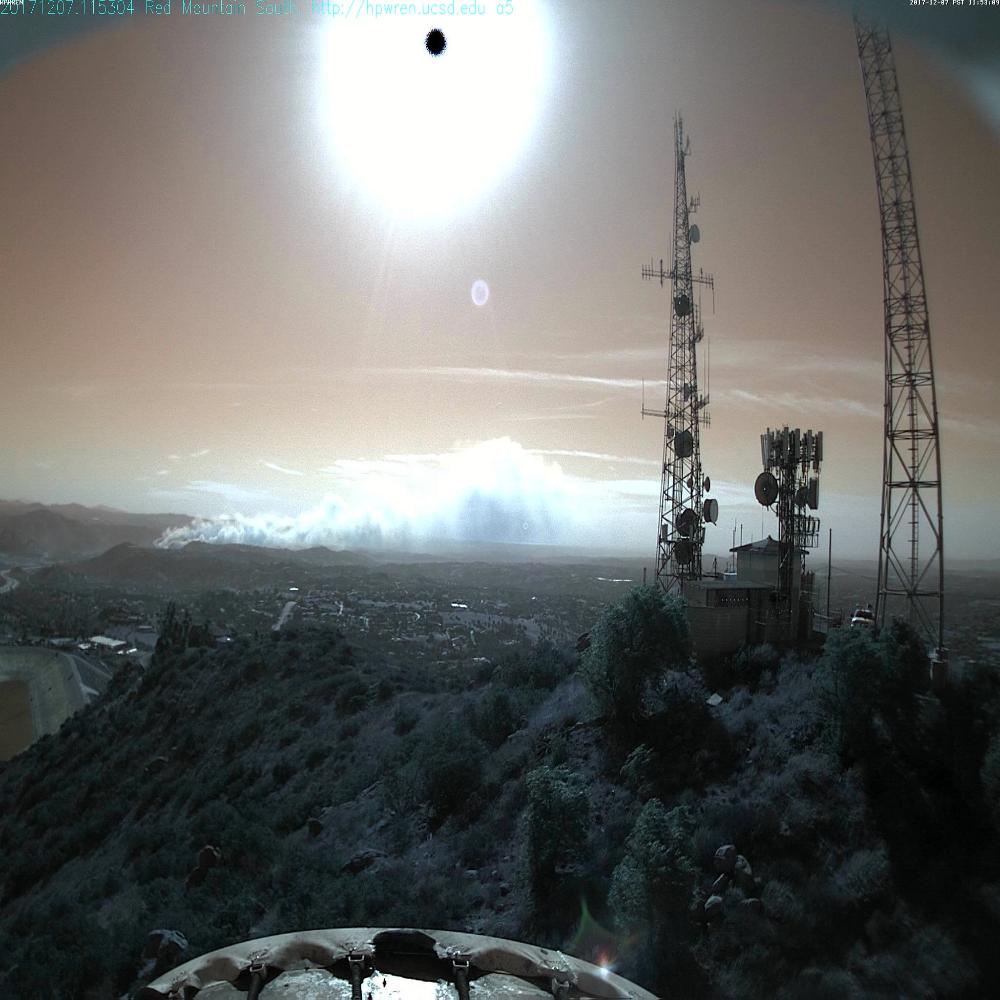

In [46]:
import random
from PIL import Image

# loop over the image paths
FIRE_PATH = "/userdata/kerasData/HPWREN-data/AFTER/images"
imagePaths = list(paths.list_images(FIRE_PATH))

    # load the image and resize it to be a fixed 128x128 pixels,
    # ignoring aspect ratio

thing = random.choice(imagePaths)    
image = cv2.imread(thing)
image = cv2.resize(image, (1000, 1000))

img = Image.fromarray(image, "RGB")
img

## Start of Model

In [21]:
model = FireDetectionNet.build(width=128, height=128, depth=3,
    classes=2)

In [43]:
opt = SGD(lr=INIT_LR, momentum=0.9,
    decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [28]:
BATCH_SIZE = 64

#### Learning Rate Finder

In [28]:
lrf = LearningRateFinder(model)


In [ ]:
lrf.find(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    1e-10, 1e+1,
    stepsPerEpoch=np.ceil((trainX.shape[0] / float(BATCH_SIZE))),
    epochs=50,
    batchSize=BATCH_SIZE,
    classWeight=classWeight)


In [ ]:
lrf.plot_loss()
plt.savefig(LRFIND_PLOT_PATH)
print("Loss Rate finder complete")


In [ ]:
from IPython.display import Image
learningRateGraph = Image(filename=LRFIND_PLOT_PATH)
learningRateGraph


In [ ]:
import png
from PIL import Image

In [29]:
# define the initial learning rate, batch size, and number of epochs
INIT_LR = 1e-4
BATCH_SIZE = 64
NUM_EPOCHS = 1000

### Start of Training

In [30]:
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [41]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)

In [ ]:
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    callbacks=[mc],
    verbose=1)

Epoch 1/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.8407 - accuracy: 0.5399
Epoch 00001: saving model to best_model.h5
24/24 [==============================] - 11s 463ms/step - loss: 0.8374 - accuracy: 0.5408 - val_loss: 0.6649 - val_accuracy: 0.6192
Epoch 2/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.7667 - accuracy: 0.5832
Epoch 00002: saving model to best_model.h5
24/24 [==============================] - 9s 377ms/step - loss: 0.7667 - accuracy: 0.5823 - val_loss: 0.6760 - val_accuracy: 0.6192
Epoch 3/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.7442 - accuracy: 0.5867
Epoch 00003: saving model to best_model.h5
24/24 [==============================] - 10s 428ms/step - loss: 0.7520 - accuracy: 0.5790 - val_loss: 0.6724 - val_accuracy: 0.6192
Epoch 4/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.7281 - accuracy: 0.5783
Epoch 00004: saving model to best_model.h5
24/24 [==============================] - 9s 387ms

23/24 [===========================>..] - ETA: 0s - loss: 0.5912 - accuracy: 0.6420
Epoch 00061: saving model to best_model.h5
24/24 [==============================] - 9s 375ms/step - loss: 0.5902 - accuracy: 0.6446 - val_loss: 0.6886 - val_accuracy: 0.5154
Epoch 62/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.6099 - accuracy: 0.6098
Epoch 00062: saving model to best_model.h5
24/24 [==============================] - 9s 374ms/step - loss: 0.6111 - accuracy: 0.6098 - val_loss: 0.6710 - val_accuracy: 0.5404
Epoch 63/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.5681 - accuracy: 0.6552
Epoch 00063: saving model to best_model.h5
24/24 [==============================] - 10s 412ms/step - loss: 0.5710 - accuracy: 0.6499 - val_loss: 0.6656 - val_accuracy: 0.5423
Epoch 64/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.5618 - accuracy: 0.6685
Epoch 00064: saving model to best_model.h5
24/24 [==============================] - 9s 361ms/step - los

23/24 [===========================>..] - ETA: 0s - loss: 0.5120 - accuracy: 0.7105
Epoch 00121: saving model to best_model.h5
24/24 [==============================] - 9s 372ms/step - loss: 0.5105 - accuracy: 0.7115 - val_loss: 0.5330 - val_accuracy: 0.6712
Epoch 122/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.5064 - accuracy: 0.7097
Epoch 00122: saving model to best_model.h5
24/24 [==============================] - 8s 354ms/step - loss: 0.5080 - accuracy: 0.7080 - val_loss: 0.6603 - val_accuracy: 0.5885
Epoch 123/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.4902 - accuracy: 0.7344
Epoch 00123: saving model to best_model.h5
24/24 [==============================] - 10s 425ms/step - loss: 0.4885 - accuracy: 0.7370 - val_loss: 0.6652 - val_accuracy: 0.5827
Epoch 124/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.5012 - accuracy: 0.7105
Epoch 00124: saving model to best_model.h5
24/24 [==============================] - 10s 399ms/step -

23/24 [===========================>..] - ETA: 0s - loss: 0.4636 - accuracy: 0.7441
Epoch 00181: saving model to best_model.h5
24/24 [==============================] - 9s 387ms/step - loss: 0.4618 - accuracy: 0.7463 - val_loss: 0.8243 - val_accuracy: 0.6788
Epoch 182/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.4509 - accuracy: 0.7629
Epoch 00182: saving model to best_model.h5
24/24 [==============================] - 10s 422ms/step - loss: 0.4505 - accuracy: 0.7651 - val_loss: 0.4726 - val_accuracy: 0.7423
Epoch 183/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.4451 - accuracy: 0.7575
Epoch 00183: saving model to best_model.h5
24/24 [==============================] - 11s 440ms/step - loss: 0.4454 - accuracy: 0.7552 - val_loss: 0.5733 - val_accuracy: 0.6981
Epoch 184/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.4590 - accuracy: 0.7559
Epoch 00184: saving model to best_model.h5
24/24 [==============================] - 10s 404ms/step 

23/24 [===========================>..] - ETA: 0s - loss: 0.4252 - accuracy: 0.7734
Epoch 00241: saving model to best_model.h5
24/24 [==============================] - 9s 389ms/step - loss: 0.4217 - accuracy: 0.7758 - val_loss: 0.4318 - val_accuracy: 0.7635
Epoch 242/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3959 - accuracy: 0.7881
Epoch 00242: saving model to best_model.h5
24/24 [==============================] - 9s 354ms/step - loss: 0.3946 - accuracy: 0.7885 - val_loss: 0.8208 - val_accuracy: 0.6904
Epoch 243/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.4159 - accuracy: 0.7826
Epoch 00243: saving model to best_model.h5
24/24 [==============================] - 10s 431ms/step - loss: 0.4188 - accuracy: 0.7806 - val_loss: 0.6523 - val_accuracy: 0.6942
Epoch 244/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.4007 - accuracy: 0.7888
Epoch 00244: saving model to best_model.h5
24/24 [==============================] - 9s 380ms/step - 

23/24 [===========================>..] - ETA: 0s - loss: 0.3650 - accuracy: 0.8098
Epoch 00301: saving model to best_model.h5
24/24 [==============================] - 10s 434ms/step - loss: 0.3627 - accuracy: 0.8112 - val_loss: 0.7825 - val_accuracy: 0.6769
Epoch 302/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3847 - accuracy: 0.8035
Epoch 00302: saving model to best_model.h5
24/24 [==============================] - 9s 369ms/step - loss: 0.3822 - accuracy: 0.8072 - val_loss: 0.5831 - val_accuracy: 0.7288
Epoch 303/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3579 - accuracy: 0.8301
Epoch 00303: saving model to best_model.h5
24/24 [==============================] - 9s 366ms/step - loss: 0.3566 - accuracy: 0.8286 - val_loss: 0.4827 - val_accuracy: 0.7404
Epoch 304/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3595 - accuracy: 0.8196
Epoch 00304: saving model to best_model.h5
24/24 [==============================] - 9s 358ms/step - 

23/24 [===========================>..] - ETA: 0s - loss: 0.3543 - accuracy: 0.8268
Epoch 00361: saving model to best_model.h5
24/24 [==============================] - 9s 366ms/step - loss: 0.3519 - accuracy: 0.8262 - val_loss: 0.8817 - val_accuracy: 0.5923
Epoch 362/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3721 - accuracy: 0.8120
Epoch 00362: saving model to best_model.h5
24/24 [==============================] - 9s 364ms/step - loss: 0.3763 - accuracy: 0.8099 - val_loss: 1.5030 - val_accuracy: 0.6404
Epoch 363/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3535 - accuracy: 0.8125
Epoch 00363: saving model to best_model.h5
24/24 [==============================] - 9s 384ms/step - loss: 0.3543 - accuracy: 0.8138 - val_loss: 0.6407 - val_accuracy: 0.7327
Epoch 364/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3471 - accuracy: 0.8336
Epoch 00364: saving model to best_model.h5
24/24 [==============================] - 8s 339ms/step - l

23/24 [===========================>..] - ETA: 0s - loss: 0.3339 - accuracy: 0.8168
Epoch 00421: saving model to best_model.h5
24/24 [==============================] - 9s 360ms/step - loss: 0.3340 - accuracy: 0.8173 - val_loss: 0.4539 - val_accuracy: 0.7923
Epoch 422/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3560 - accuracy: 0.8252
Epoch 00422: saving model to best_model.h5
24/24 [==============================] - 9s 357ms/step - loss: 0.3549 - accuracy: 0.8273 - val_loss: 0.2867 - val_accuracy: 0.8615
Epoch 423/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3129 - accuracy: 0.8455
Epoch 00423: saving model to best_model.h5
24/24 [==============================] - 9s 369ms/step - loss: 0.3149 - accuracy: 0.8420 - val_loss: 0.4107 - val_accuracy: 0.7885
Epoch 424/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3248 - accuracy: 0.8371
Epoch 00424: saving model to best_model.h5
24/24 [==============================] - 9s 383ms/step - l

23/24 [===========================>..] - ETA: 0s - loss: 0.3289 - accuracy: 0.8287
Epoch 00481: saving model to best_model.h5
24/24 [==============================] - 8s 340ms/step - loss: 0.3277 - accuracy: 0.8286 - val_loss: 1.9913 - val_accuracy: 0.6615
Epoch 482/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3323 - accuracy: 0.8357
Epoch 00482: saving model to best_model.h5
24/24 [==============================] - 9s 363ms/step - loss: 0.3334 - accuracy: 0.8353 - val_loss: 0.3023 - val_accuracy: 0.8212
Epoch 483/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3308 - accuracy: 0.8399
Epoch 00483: saving model to best_model.h5
24/24 [==============================] - 9s 383ms/step - loss: 0.3288 - accuracy: 0.8407 - val_loss: 1.0283 - val_accuracy: 0.6442
Epoch 484/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3205 - accuracy: 0.8315
Epoch 00484: saving model to best_model.h5
24/24 [==============================] - 9s 391ms/step - l

23/24 [===========================>..] - ETA: 0s - loss: 0.3179 - accuracy: 0.8343
Epoch 00541: saving model to best_model.h5
24/24 [==============================] - 9s 381ms/step - loss: 0.3182 - accuracy: 0.8347 - val_loss: 0.4278 - val_accuracy: 0.7904
Epoch 542/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.2971 - accuracy: 0.8725
Epoch 00542: saving model to best_model.h5
24/24 [==============================] - 9s 388ms/step - loss: 0.2959 - accuracy: 0.8733 - val_loss: 0.6024 - val_accuracy: 0.7250
Epoch 543/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3268 - accuracy: 0.8441
Epoch 00543: saving model to best_model.h5
24/24 [==============================] - 9s 391ms/step - loss: 0.3280 - accuracy: 0.8434 - val_loss: 0.5650 - val_accuracy: 0.7192
Epoch 544/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3000 - accuracy: 0.8485
Epoch 00544: saving model to best_model.h5
24/24 [==============================] - 9s 390ms/step - l

23/24 [===========================>..] - ETA: 0s - loss: 0.3055 - accuracy: 0.8566
Epoch 00601: saving model to best_model.h5
24/24 [==============================] - 9s 384ms/step - loss: 0.3033 - accuracy: 0.8574 - val_loss: 0.2337 - val_accuracy: 0.8423
Epoch 602/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.2688 - accuracy: 0.8692
Epoch 00602: saving model to best_model.h5
24/24 [==============================] - 9s 386ms/step - loss: 0.2691 - accuracy: 0.8695 - val_loss: 0.2860 - val_accuracy: 0.8538
Epoch 603/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.2893 - accuracy: 0.8524
Epoch 00603: saving model to best_model.h5
24/24 [==============================] - 9s 393ms/step - loss: 0.2870 - accuracy: 0.8527 - val_loss: 2.2942 - val_accuracy: 0.6327
Epoch 604/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.3305 - accuracy: 0.8434
Epoch 00604: saving model to best_model.h5
24/24 [==============================] - 9s 379ms/step - l

23/24 [===========================>..] - ETA: 0s - loss: 0.2873 - accuracy: 0.8622
Epoch 00661: saving model to best_model.h5
24/24 [==============================] - 9s 391ms/step - loss: 0.2854 - accuracy: 0.8628 - val_loss: 0.5286 - val_accuracy: 0.7442
Epoch 662/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.2927 - accuracy: 0.8497
Epoch 00662: saving model to best_model.h5
24/24 [==============================] - 10s 397ms/step - loss: 0.2967 - accuracy: 0.8481 - val_loss: 0.3218 - val_accuracy: 0.8481
Epoch 663/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.2934 - accuracy: 0.8510
Epoch 00663: saving model to best_model.h5
24/24 [==============================] - 9s 376ms/step - loss: 0.2943 - accuracy: 0.8507 - val_loss: 0.3290 - val_accuracy: 0.8077
Epoch 664/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.2818 - accuracy: 0.8622
Epoch 00664: saving model to best_model.h5
24/24 [==============================] - 8s 351ms/step - 

23/24 [===========================>..] - ETA: 0s - loss: 0.2875 - accuracy: 0.8573
Epoch 00721: saving model to best_model.h5
24/24 [==============================] - 8s 354ms/step - loss: 0.2850 - accuracy: 0.8588 - val_loss: 1.3287 - val_accuracy: 0.7038
Epoch 722/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.2735 - accuracy: 0.8699
Epoch 00722: saving model to best_model.h5
24/24 [==============================] - 9s 355ms/step - loss: 0.2710 - accuracy: 0.8708 - val_loss: 0.4873 - val_accuracy: 0.7788
Epoch 723/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.2835 - accuracy: 0.8580
Epoch 00723: saving model to best_model.h5
24/24 [==============================] - 9s 367ms/step - loss: 0.2818 - accuracy: 0.8574 - val_loss: 0.4464 - val_accuracy: 0.7981
Epoch 724/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.2782 - accuracy: 0.8601
Epoch 00724: saving model to best_model.h5
24/24 [==============================] - 9s 360ms/step - l

23/24 [===========================>..] - ETA: 0s - loss: 0.2670 - accuracy: 0.8643
Epoch 00781: saving model to best_model.h5
24/24 [==============================] - 10s 399ms/step - loss: 0.2671 - accuracy: 0.8628 - val_loss: 0.5297 - val_accuracy: 0.7596
Epoch 782/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.2772 - accuracy: 0.8608
Epoch 00782: saving model to best_model.h5
24/24 [==============================] - 9s 363ms/step - loss: 0.2800 - accuracy: 0.8581 - val_loss: 0.2685 - val_accuracy: 0.8577
Epoch 783/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.2696 - accuracy: 0.8755
Epoch 00783: saving model to best_model.h5
24/24 [==============================] - 8s 352ms/step - loss: 0.2697 - accuracy: 0.8748 - val_loss: 2.1190 - val_accuracy: 0.6308
Epoch 784/1000
23/24 [===========================>..] - ETA: 0s - loss: 0.2773 - accuracy: 0.8560
Epoch 00784: saving model to best_model.h5
24/24 [==============================] - 9s 357ms/step - 

In [ ]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=config.BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=config.CLASSES))
 
# serialize the model to disk
print("[INFO] serializing network to '{}'...".format(config.MODEL_PATH))
model.save(config.MODEL_PATH)
 
# construct a plot that plots and saves the training history
N = np.arange(0, config.NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(config.TRAINING_PLOT_PATH)

1 -00180


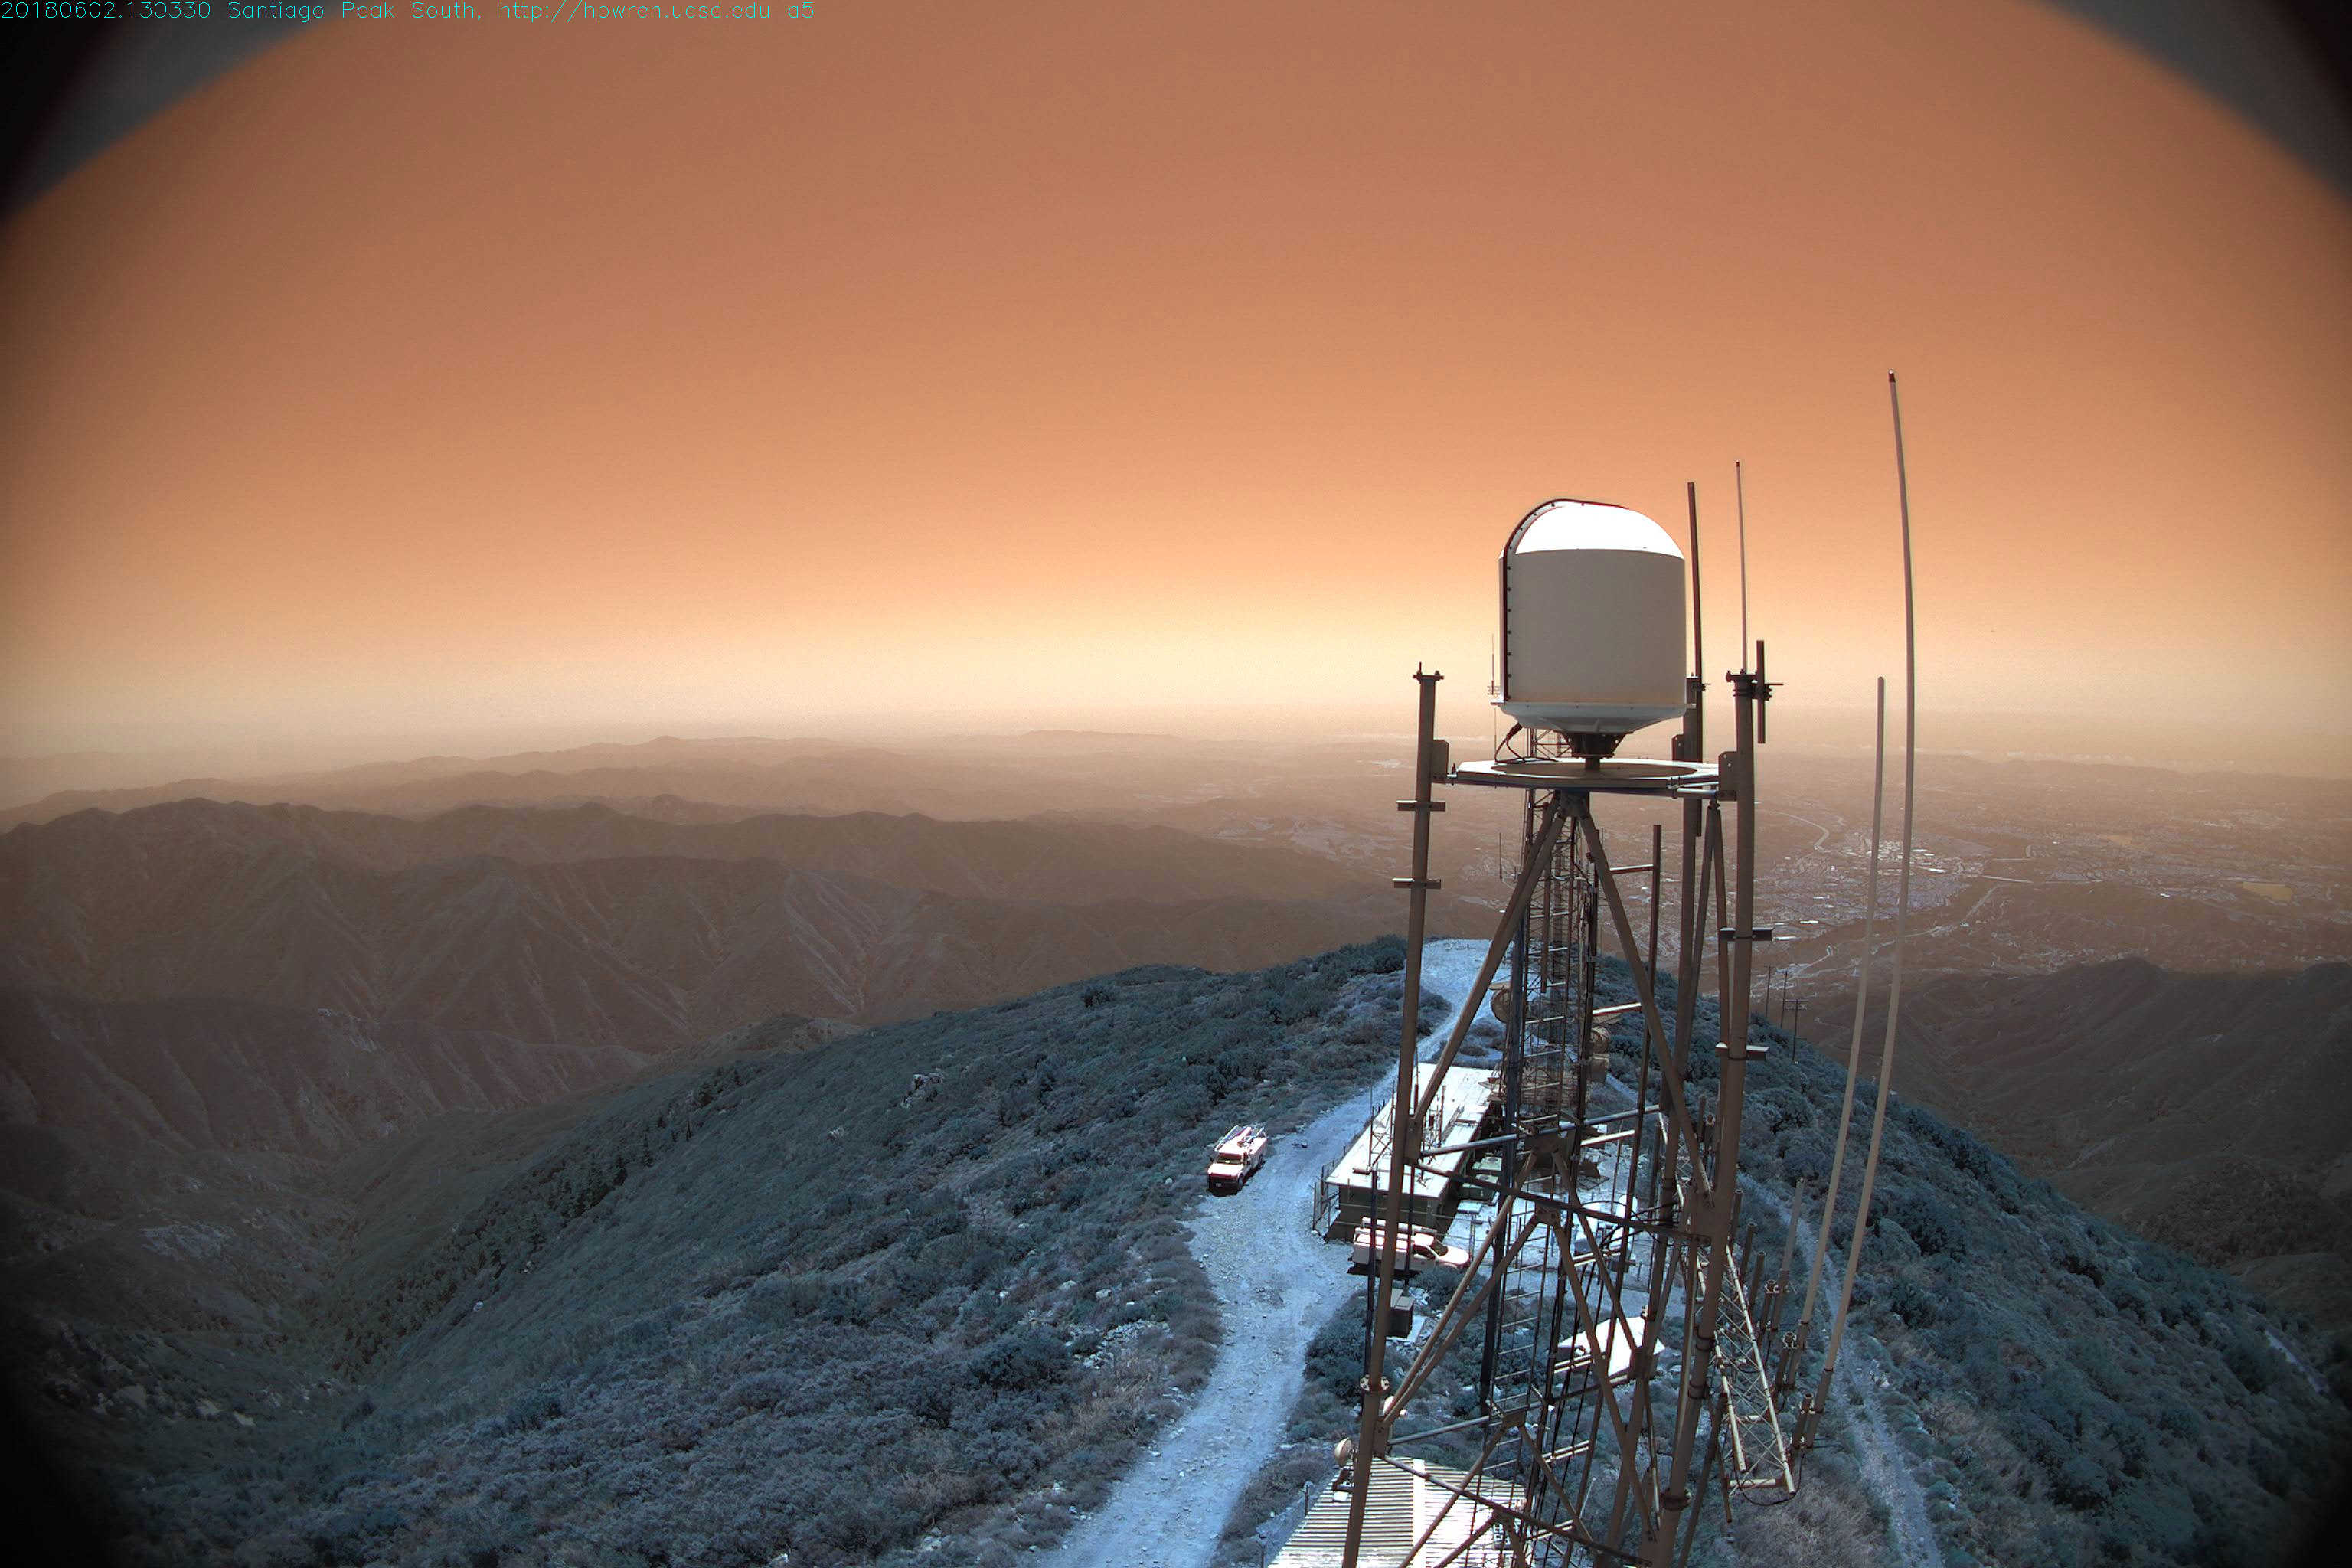

In [89]:
import random
from PIL import Image

firePaths = list(paths.list_images(FIRE_PATH))
nonFirePaths = list(paths.list_images(NON_FIRE_PATH))
imagePaths = firePaths + nonFirePaths

imagePath = random.sample(imagePaths, 1)[0]

img = cv2.resize(cv2.imread(imagePath), (128,128))
img = img.astype("float32")/255
print(np.argmax(model.predict(np.expand_dims(img, axis=0))[0]), imagePath.split(":")[1][:-4])
Image.fromarray(cv2.imread(imagePath), "RGB")



In [ ]:
import random
from PIL import Image

firePaths = list(paths.list_images("20180611fallbrookrmwmobocAFTER"))
nonFirePaths = list(paths.list_images("20180611fallbrookrmwmobocBEFORE"))
imagePaths = firePaths + nonFirePaths

MaxnumberofImg = len(imagePaths)

numberofImg = 0

for imagePath in imagePaths:
    img = cv2.resize(cv2.imread(imagePaths[numberofImg]), (128,128))
    img = img.astype("float32")/255
    print(np.argmax(model.predict(np.expand_dims(img, axis=0))[0]), imagePaths[numberofImg].split(":")[1][:-4])
    Image.fromarray(cv2.imread(imagePath), "RGB")



In [34]:
model.load_weights("best_model.h5")

In [48]:
# model.evaluate(testX,testY)

testX

array([[[[0.01176471, 0.01176471, 0.02352941],
         [0.29803923, 0.47843137, 0.47843137],
         [0.02352941, 0.01568628, 0.01176471],
         ...,
         [0.03137255, 0.03137255, 0.03137255],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01568628, 0.01568628, 0.01568628]],

        [[0.03529412, 0.01176471, 0.01568628],
         [0.01176471, 0.01960784, 0.01960784],
         [0.01568628, 0.01568628, 0.01960784],
         ...,
         [0.01568628, 0.01568628, 0.01568628],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01960784, 0.01960784, 0.01960784]],

        [[0.01176471, 0.01176471, 0.01176471],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01176471, 0.01176471, 0.01176471],
         ...,
         [0.01568628, 0.01568628, 0.01568628],
         [0.01568628, 0.01568628, 0.01568628],
         [0.01176471, 0.01176471, 0.01176471]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.00392157, 0.00392157, 0.00392157]

### Transfer to TF.LITE

In [92]:
from tensorflow import lite

In [93]:
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [96]:
open("wildfiretflite_model.tflite", "wb").write(tflite_model)

8501404